In [3]:
import pandas as pd
import numpy as np
import re
import random
import spacy
nlp = spacy.load("fr_core_news_lg")
import pickle
import itertools
from tqdm.notebook import tqdm

# X pretreatement functions

In [4]:
df = pd.read_excel("./algorel_fullDb_190223.xlsx")
df.head()

,TaxonomyPath,TaxonomyCode,Texts,ProductUid
0,Outillage - Droguerie - Quincaillerie/Drogueri...,OU_4/18/3/,PROPFEU CREME LUSTRANTE boite 220 ml\nwww.gebs...,501064435
1,Chauffage/Fumisterie/Accessoires de fumisterie,CH_2/11/6/,TRESSE EXTENSIBLE EN FIBRE DE VERRE (Diam 9/10...,501064447
2,Chauffage/Fumisterie/Accessoires de fumisterie,CH_2/11/6/,TRESSE EXTENSIBLE EN FIBRE DE VERRE (Diam 11/1...,501064448
3,Outillage - Droguerie - Quincaillerie/Outillag...,OU_4/2/9/1/,ROULEAU ATELIER WATERPROOF Rouleau 38 mm x 25 ...,501064453
4,Outillage - Droguerie - Quincaillerie/Drogueri...,OU_4/18/4/4/,BANDE D'ETANCHEITE couleur aluminium rouleau ...,501064455


In [5]:
df.isna().sum()

TaxonomyPath    6505
TaxonomyCode    6505
Texts              0
ProductUid         0
dtype: int64

<p style='background-color:red; '> We drop the 6505 items without Taxonomy </p>


In [6]:
df.dropna(inplace=True)
print(len(df))
df.isna().sum()

95855


TaxonomyPath    0
TaxonomyCode    0
Texts           0
ProductUid      0
dtype: int64

In [7]:
keyword = "nicoll"
db = df.loc[df.Texts.str.lower().str.contains(keyword),:]
len(db)

1291

# Rouge

In [116]:
from rouge import Rouge 

hypothesis = "the #### transcript is a written version of each day 's cnn student news program use this transcript to he    lp students with reading comprehension and vocabulary use the weekly newsquiz to test your knowledge of storie s you     saw on cnn student news"

reference = "this page includes the show transcript use the transcript to help students with reading comprehension and     vocabulary at the bottom of the page , comment for a chance to be mentioned on cnn student news . you must be a teac    her or a student age # # or older to request a mention on the cnn student news roll call . the weekly newsquiz tests     students ' knowledge of even ts in the news"

rouge = Rouge()
scores = rouge.get_scores(hypothesis, reference)

In [117]:
scores

[{'rouge-1': {'r': 0.42857142857142855,
   'p': 0.5833333333333334,
   'f': 0.49411764217577864},
  'rouge-2': {'r': 0.18571428571428572,
   'p': 0.3170731707317073,
   'f': 0.23423422957552154},
  'rouge-l': {'r': 0.3877551020408163,
   'p': 0.5277777777777778,
   'f': 0.44705881864636676}}]

In [118]:
%%time 
rouge = Rouge()
output=[]
for i,j in tqdm(itertools.combinations(db.index,2)):
    h = db.loc[i,"Texts"]
    r = db.loc[j,"Texts"]
    if np.abs(1-len(h)/len(r))>0.1:
        scores=0
    else:
        scores = rouge.get_scores(h, r)
        scores = scores[0]['rouge-1']['f']
    output.append(np.array([i,j,scores]))

0it [00:00, ?it/s]

Wall time: 2h 56min 32s


In [119]:
output=np.array(output)
output.shape

(832695, 3)

In [120]:
output = pd.DataFrame(output,columns=("Index_A",'Index_B',"Rouge"))
output = output.astype({"Index_A":int,"Index_B":int})
output.sort_values(by="Rouge",ascending=False,inplace=True)

In [121]:
def A_not_B(index_a,index_b):
    """
    return from db the words that are in column "Texts" and index "index_a" which
    are not in the same db and column at index "index_b"
    """
    a = db.loc[index_a,"Texts"]
    b = db.loc[index_b,"Texts"]
    return ", ".join(set(a.split()).difference(set(b.split())))

In [122]:
output["In_A_not_B"] = output.apply(lambda x:A_not_B(x.Index_A,x.Index_B) if x.Rouge>0 else "not match",axis=1)
output["In_B_not_A"] = output.apply(lambda x:A_not_B(x.Index_B,x.Index_A) if x.Rouge>0 else "not match",axis=1)

In [123]:
output

,Index_A,Index_B,Rouge,In_A_not_B,In_B_not_A
789036,62326,62328,0.991561,"TF18, 0.081","0.046, TF188MF"
387078,21405,45011,0.989691,TD100S,"prem, TD100PS, Avec"
394823,21413,62330,0.989429,"0.109, d.50, TJ18","TJ38, d.50/32, 0.079"
601093,44850,82685,0.989305,TD80S,"prem, TD80PS, Avec"
580770,44821,82517,0.989154,"d.32, 0.075, AF14","50, 0.170, AJ14, d.50"
...,...,...,...,...,...
312975,21329,86138,0.000000,not match,not match
312976,21329,86139,0.000000,not match,not match
312977,21329,86140,0.000000,not match,not match
312978,21329,86141,0.000000,not match,not match


In [124]:
output = output.merge(db[["ProductUid"]],left_on="Index_A",right_index=True)
output.rename(columns={"ProductUid":"ProductUid_A"},inplace=True)
output = output.merge(db[["ProductUid"]],left_on="Index_B",right_index=True)
output.rename(columns={"ProductUid":"ProductUid_B"},inplace=True)
output

,Index_A,Index_B,Rouge,In_A_not_B,In_B_not_A,ProductUid_A,ProductUid_B
789036,62326,62328,0.991561,"TF18, 0.081","0.046, TF188MF",501059169,501059172
387305,21405,62328,0.000000,not match,not match,501059150,501059172
394821,21413,62328,0.947146,"0.109, ME, 0.100, CLASSEMENT_EUROCLASSE, d.50,...","d’eau., E, 0.046, 0.040, Inventé, marché.<br>N...",501059211,501059172
600861,44850,62328,0.000000,not match,not match,501059160,501059172
580706,44821,62328,0.822270,"d’impuretés</li><li>Rayon, collecteurs, >, dim...","ou, rayon, eaux</li><li>Becquet, l'intérieur/É...",501056883,501059172
...,...,...,...,...,...,...,...
1294,433,2054,0.000000,not match,not match,501058387,500608610
3869,435,2054,0.000000,not match,not match,501058509,500608610
5155,624,2054,0.000000,not match,not match,501057396,500608610
1,432,434,0.000000,not match,not match,501058910,501058449


In [125]:
output.drop(columns=["Index_A", "Index_B"],inplace=True)

In [126]:
output.sort_values(by="Rouge",ascending=False, inplace=True)
output

,Rouge,In_A_not_B,In_B_not_A,ProductUid_A,ProductUid_B
789036,0.991561,"TF18, 0.081","0.046, TF188MF",501059169,501059172
387078,0.989691,TD100S,"prem, TD100PS, Avec",501059150,501059149
394823,0.989429,"0.109, d.50, TJ18","TJ38, d.50/32, 0.079",501059211,501059230
601093,0.989305,TD80S,"prem, TD80PS, Avec",501059160,501059159
580770,0.989154,"d.32, 0.075, AF14","50, 0.170, AJ14, d.50",501056883,501056936
...,...,...,...,...,...
778372,0.000000,not match,not match,501058874,501058780
727087,0.000000,not match,not match,501057108,501058780
573097,0.000000,not match,not match,501056842,501058780
517836,0.000000,not match,not match,501057064,501058780


In [130]:
output.to_excel(keyword + "_rouge.xlsx",index=False)

# Levenshtein

In [131]:
db = df.loc[df.Texts.str.lower().str.contains(keyword),:]
len(db)

1291

In [132]:
db

,TaxonomyPath,TaxonomyCode,Texts,ProductUid
432,Plomberie/Tube et raccord/Canalisation PVC/Rac...,PL_5/1/4/2/1/,Manchon de dilatation simple mf d.80\nwww.mano...,501058910
433,Plomberie/Toiture et couverture/Gouttière et r...,PL_5/10/2/2/,Collier bride insert p.7/150 d.80 marron\nwww....,501058387
434,Plomberie/Toiture et couverture/Gouttière et r...,PL_5/10/2/2/,Coude mf 45' d.100 gris\nwww.manomano.fr\nCT4G...,501058449
435,Plomberie/Non catégorisé,PL_5/13/,Element de courette anglaise 130\nwww.manomano...,501058509
624,Plomberie/Arrosage/De surface,PL_5/12/1/,Boite de robinet maraicher rob.20/27\nwww.nico...,501057396
...,...,...,...,...
94518,Sanitaire/Pièces détachées,SA_6/11/,Dvab-embout de clapet pour reglage hauteur\n04...,501056782
95012,Plomberie/Évacuation/Vidage - Siphon - Bonde -...,PL_5/6/1/2/,D580-se siphon grille garde 50mm/580-600\nwww....,501056771
95013,Sanitaire/Pièces détachées,SA_6/11/,D690a-capot pr receveur 90 / abs chrome\nwww.m...,501056772
98076,Sanitaire/Équipement WC/Raccordement WC/Évacua...,SA_6/3/10/2/,Pipe wc sortie droite d.100 joint 85/107 vrac\...,501058980


In [133]:
from Levenshtein import ratio
from Levenshtein import distance
print(ratio("Lionel", "2lionel3"), distance("Lionel", "2lionel3"))
print(f"ratio = nombre caractère communs 5 / taille moyenne = {5/np.average([6,8])}")

0.7142857142857143 3
ratio = nombre caractère communs 5 / taille moyenne = 0.7142857142857143


In [137]:
%%time 

output=[]
for i,j in tqdm(itertools.combinations(db.index,2)):
    h = db.loc[i,"Texts"].split("\n")[0]
    r = db.loc[j,"Texts"].split("\n")[0]
#     if np.abs(1-len(h)/len(r))>0.3:
#         scores=0
#     else:
#         scores = ratio(h, r)
    scores = ratio(h, r)
    output.append(np.array([i,j,scores]))

0it [00:00, ?it/s]

Wall time: 20 s


In [138]:
output = pd.DataFrame(output,columns=("Index_A",'Index_B',"Levenshtein"))
output = output.astype({"Index_A":int,"Index_B":int})
output.sort_values(by="Levenshtein",ascending=False,inplace=True)
output["In_A_not_B"] = output.apply(lambda x:A_not_B(x.Index_A,x.Index_B) if x.Levenshtein>0 else "not match",axis=1)
output["In_B_not_A"] = output.apply(lambda x:A_not_B(x.Index_B,x.Index_A) if x.Levenshtein>0 else "not match",axis=1)
output = output.merge(db[["ProductUid"]],left_on="Index_A",right_index=True)
output.rename(columns={"ProductUid":"ProductUid_A"},inplace=True)
output = output.merge(db[["ProductUid"]],left_on="Index_B",right_index=True)
output.rename(columns={"ProductUid":"ProductUid_B"},inplace=True)
output

,Index_A,Index_B,Levenshtein,In_A_not_B,In_B_not_A,ProductUid_A,ProductUid_B
673604,44967,62297,0.988764,"0.190, 42.750, d.140, 0.150, GE-MF, MYH, 140, ...","0.050, d.40, MHH, 0.140, PE-MF, 0.112, 40, 3.500",501058920,501058903
646625,44921,62297,0.363636,"ou, cloison, 1/2"", après, (Plaque, Obligatoire...","horizontale, leur, tous, constance, microporeu...",501058681,501058903
41717,3531,62297,0.463415,"qu'en, facile, jonctions, tant, Tampon:, œuvre...","horizontale, absorbant, tube, Manchon, tous, C...",501058719,501058903
594665,44841,62297,0.356164,"d’impuretés</li><li>Rayon, collecteurs, ou, se...","horizontale, absorbant, Manchon, tous, n’impor...",501057733,501058903
462140,21488,62297,0.338028,"sens, jonctions, compacité, toutes, tout, norm...","horizontale, absorbant, Manchon, tous, n’impor...",501058489,501058903
...,...,...,...,...,...,...,...
2583,434,2214,0.230769,"Modele, ses, 100, PVC., femelle-femelle, Volum...","réduit</li><li>Profil, être, COMAP, <span>inst...",501058449,500666143
1295,433,2214,0.231884,"PP, ou, Modele, O80., ses, Noir,, 80, l'une, V...","réduit</li><li>Profil, être, COMAP, <span>inst...",501058387,500666143
6441,1199,2214,0.203390,"PP, ou, TPE, commande:, BAIGNOIRE, rexel.fr:, ...","réduit</li><li>Profil, être, COMAP, <span>inst...",501056561,500666143
3870,435,2214,0.229508,"sanitaire, ou, assuré, empilable, Élément, Mod...","réduit</li><li>Profil, être, COMAP, <span>inst...",501058509,500666143


In [139]:
output.drop(columns=["Index_A", "Index_B"],inplace=True)
output.sort_values(by="Levenshtein",ascending=False, inplace=True)
output.to_excel(keyword + "_levenshtein.xlsx",index=False)

# Compare Rouge and Levenshtein

In [140]:
df_rouge = pd.read_excel("./nicoll_rouge.xlsx")
df_levenshtein = pd.read_excel("./nicoll_levenshtein.xlsx")

In [141]:
len(df_rouge),len(df_levenshtein)

(832695, 832695)

In [142]:
df_rouge.head()

,Rouge,In_A_not_B,In_B_not_A,ProductUid_A,ProductUid_B
0,0.991561,"TF18, 0.081","0.046, TF188MF",501059169,501059172
1,0.989691,TD100S,"prem, TD100PS, Avec",501059150,501059149
2,0.989429,"0.109, d.50, TJ18","TJ38, d.50/32, 0.079",501059211,501059230
3,0.989305,TD80S,"prem, TD80PS, Avec",501059160,501059159
4,0.989154,"d.32, 0.075, AF14","50, 0.170, AJ14, d.50",501056883,501056936


In [143]:
df_rouge["variant"] = df_rouge.apply(lambda x:(min(x.ProductUid_A,x.ProductUid_B),max(x.ProductUid_A,x.ProductUid_B)),axis=1)
df_levenshtein["variant"] = df_levenshtein.apply(lambda x:(min(x.ProductUid_A,x.ProductUid_B),max(x.ProductUid_A,x.ProductUid_B)),axis=1)

In [148]:
df_levenshtein.reset_index(inplace=True)

In [150]:
df_levenshtein.rename(columns={'index':"rank_levenshtein"},inplace=True)
df_levenshtein.head()

,rank_levenshtein,Levenshtein,In_A_not_B,In_B_not_A,ProductUid_A,ProductUid_B,variant
0,0,0.988764,"0.190, 42.750, d.140, 0.150, GE-MF, MYH, 140, ...","0.050, d.40, MHH, 0.140, PE-MF, 0.112, 40, 3.500",501058920,501058903,"(501058903, 501058920)"
1,1,0.988764,"Matière:, vissage.<br>Cette, sanitaire,<br>•, ...","KOMO,, Label:, faïence.</p><p>Classes, »</p>, ...",501058681,501058678,"(501058678, 501058681)"
2,2,0.986667,"E, 0.058, 0.290, d.140, 0.152, 0.151, FY, Inve...","0.050, ME, d.40, Avec, CLASSEMENT_EUROCLASSE, ...",501058719,501058554,"(501058554, 501058719)"
3,3,0.982456,"0.080, se, collecteurs, ou, >, 67,3°, «, il, j...","sanitaire, ses, supprimer, La, femelle-femelle...",501057109,501057729,"(501057109, 501057729)"
4,4,0.982456,"BY18, d.140, 0.910, 0.340, 0.150, GE-MF, 127.5...","0.080, 3.840, 0.120, d.40, BH18, 0.040, 0.070,...",501057733,501057110,"(501057110, 501057733)"


In [153]:
df_consolidated = df_rouge.merge(df_levenshtein[["rank_levenshtein","Levenshtein","variant"]], left_on='variant',right_on="variant")
df_consolidated.to_excel(keyword + "_consolidated.xlsx",index=True)

## Are the distribution same ?

In [12]:
for i in [100,500,2500,10000,50000,100000]:
    print("% of top",i,"Levenshtein in the top of Rouge:", np.average(df_levenshtein.loc[:i,"variant"].isin(df_rouge.loc[:i,"variant"])))

% of top 100 Levenshtein in the top of Rouge: 0.039603960396039604
% of top 500 Levenshtein in the top of Rouge: 0.10978043912175649
% of top 2500 Levenshtein in the top of Rouge: 0.44582167133146744
% of top 10000 Levenshtein in the top of Rouge: 0.6365363463653635
% of top 50000 Levenshtein in the top of Rouge: 0.47259054818903623
% of top 100000 Levenshtein in the top of Rouge: 0.3899261007389926


In [17]:
x = np.array(range(0,102,2))
ry = np.percentile(df_rouge.Rouge,x)
ly = np.percentile(df_levenshtein.Levenshtein,x)

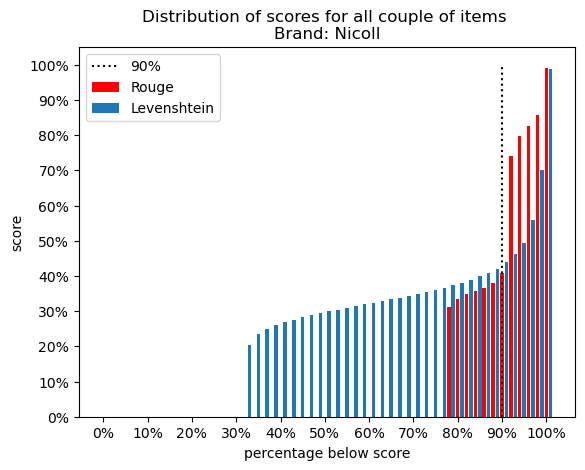

In [78]:
import matplotlib.pyplot as plt
plt.bar(x,ry,label="Rouge",color="red")
plt.bar(x+1,ly,label="Levenshtein")
plt.vlines(90,0,1,'k',linestyles='dotted',label="90%")
plt.xticks(range(0,102,10),labels=[str(i)+"%" for i in range(0,102,10)])
plt.yticks(np.linspace(0,1,11),labels=[str(i)+"%" for i in range(0,102,10)])
plt.title("Distribution of scores for all couple of items \nBrand: " + keyword.capitalize(), )
plt.xlabel("percentage below score")
plt.ylabel("score")
plt.legend();


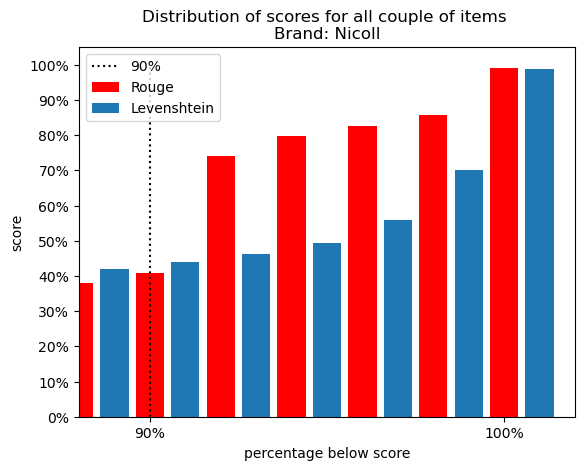

In [79]:
plt.bar(x,ry,label="Rouge",color="red")
plt.bar(x+1,ly,label="Levenshtein")
plt.vlines(90,0,1,'k',linestyles='dotted',label="90%")
plt.xticks(range(0,102,10),labels=[str(i)+"%" for i in range(0,102,10)])
plt.yticks(np.linspace(0,1,11),labels=[str(i)+"%" for i in range(0,102,10)])
plt.title("Distribution of scores for all couple of items \nBrand: " + keyword.capitalize(), )
plt.xlabel("percentage below score")
plt.ylabel("score")
plt.legend();
plt.xlim([88,102]);

## Examples

In [51]:
def check_rouge_levenshtein(df_rouge,df_levenshtein, df_master, id):
    variant = df_rouge.loc[id,"variant"]
    rouge_score = df_rouge.loc[id,"Rouge"]
    levenshtein_score = df_levenshtein.loc[df_levenshtein.variant==variant,"Levenshtein"].iloc[0]
    levenshtein_id = df_levenshtein.loc[df_levenshtein.variant==variant,:].index[0]
    text_A = df_master.loc[df_master.ProductUid==variant[0],"Texts"].iloc[0]
    text_B = df_master.loc[df_master.ProductUid==variant[1],"Texts"].iloc[0]
    return (variant, id, rouge_score, levenshtein_id,levenshtein_score,text_A,text_B)

In [52]:
def print_compare(variant, id, rouge_score, levenshtein_id,levenshtein_score,text_A,text_B):
    print(f"Rouge score: {rouge_score:.3f}, Rouge Rank: {id}")
    print(f"Levenshtein score: {levenshtein_score:.3f}, Levenshtein Rank: {levenshtein_id}")
    print("=================================================================================")
    print(text_A)
    print("=================================================================================")
    print("=================================================================================")
    print(text_B)

### Levenshtein puts it higher and not a variant

In [53]:
np.sum(df_rouge.Rouge>0.7)

68918

https://www.google.com/search?q=Collier+bride+insert+p.7%2F150+d.125+blanc&oq=Collier+bride+insert+p.7%2F150+d.125+blanc&aqs=chrome..69i57j0i546l3.531j0j7&sourceid=chrome&ie=UTF-8
https://www.google.com/search?q=Collier+monobloc+90x56+ovation+28+blanc&oq=Collier+monobloc+90x56+ovation+28+blanc&aqs=chrome..69i57j0i546j0i30i546.229j0j7&sourceid=chrome&ie=UTF-8


In [54]:
print_compare(*check_rouge_levenshtein(df_rouge,df_levenshtein,df,68918))

Rouge score: 0.700, Rouge Rank: 68918
Levenshtein score: 0.506, Rouge Rank: 47092
Collier monobloc 90x56 ovation 28 blanc
www.nicoll.fr
CONGTB
NICOLL
Les solutions pour l'extérieur/Equipements de toiture & gouttières/Gouttières
GT 28 COLLIERS OVATION
Désignation www.nicoll.fr: Collier pour tube de descente ovoïde 90x56
Avantages: <h3>Les + Nicoll <span>performance</span></h3><ul><li>Une excellente tenue aux UV (couleur, résistance)</li><li>Disponibles en 8 coloris pour s'adapter au mieux à votre projet</li></ul><h3>Les + Nicoll <span>installation</span></h3><br>                                                        Collier lanière à fixation par crans, permettant de créer un collier glissant ou serrant en fonction de sa position
Description: <p>Accessoire permettant de fixer le tube de descente ovoïde 90x56 mm à la façade.</p>
ATTRIBUTES: Hauteur : 0.030 m | Largeur : 0.080 m Profondeur : 0.080 m | Poids : 0.024 kg | Volume : 1.920 m3 |
Hauteur: 0.030 m
Largeur: 0.080 m Profondeur
Poi

### Levenshtein puts it higher (a bit) and not a variant

In [55]:
np.sum(df_rouge.Rouge>0.8)

48231

https://www.bricozor.com/grilles-ventilation/grilles-visser-coller-nicoll.html  
https://www.cedeo.fr/p/chauffage-et-climatisation/grille-ronde-interieure-a-fermeture-avec-moustiquaire-pvc-diametre-A1825150

In [56]:
print_compare(*check_rouge_levenshtein(df_rouge,df_levenshtein,df,48231))

Rouge score: 0.800, Rouge Rank: 48231
Levenshtein score: 0.500, Rouge Rank: 47854
Grille ferm.adapt s/tuyau 125 moust.sch
www.nicoll.fr
1FATM125
NICOLL
Les solutions pour l'extérieur/Ventilation/Grilles d'aération NEOLIA®
GRILLES AERATION SACH.
Désignation www.nicoll.fr: Grille de ventilation intérieure avec moustiquaire
Avantages: <h3>Les + Nicoll <span>performance</span></h3><ul><li>Une résistance à toute épreuve</li><li>Gamme très large en matériau de synthèse ou alumimium</li><li>Nombreux coloris</li></ul><h3>Les + Nicoll <span>installation</span></h3><br>                                                        Grilles à clipser, à visser, à sceller ou à coller
Description: <p>Conçues pour ventiler efficacement le bâti et assainir l'air, les grilles d'aération Nicoll offrent une largeur de gamme qui permet tout type de pose sur tous supports, en intérieur comme en façade.</p><p>De la simple grille aux produits les plus design de la ligne Neolia, les solutions de ventilation Nicoll m

### Rouge puts it higher (a bit) is it a variant ?

In [57]:
np.sum(df_rouge.Rouge>0.82)

36372

https://www.cedeo.fr/p/chauffage-et-climatisation/grille-d-aeration-a-visser-persienne-alu-gris-1lm2020g-A1825188  

https://www.cedeo.fr/p/chauffage-et-climatisation/grille-d-aeration-a-visser-ou-a-coller-classique-carree-simple-A1825334

In [58]:
print_compare(*check_rouge_levenshtein(df_rouge,df_levenshtein,df,36372))

Rouge score: 0.820, Rouge Rank: 36372
Levenshtein score: 0.514, Rouge Rank: 44364
Grille persienne alu gris moust.20x20
www.nicoll.fr
1LM2020G
NICOLL
Les solutions pour l'extérieur/Ventilation/Grilles d'aération NEOLIA®
GRILLES METAL  - SACHET
Désignation www.nicoll.fr: Grille de ventilation aluminium à visser carrée - persiennes avec moustiquaire
Avantages: <h3>Les + Nicoll <span>performance</span></h3><ul><li>Une résistance à toute épreuve</li><li>Gamme très large en matériau de synthèse ou alumimium</li><li>Nombreux coloris</li></ul><h3>Les + Nicoll <span>installation</span></h3><br>                                                        Grilles à clipser, à visser, à sceller ou à coller
Description: <p>Conçues pour ventiler efficacement le bâti et assainir l'air, les grilles d'aération Nicoll offrent une largeur de gamme qui permet tout type de pose sur tous supports, en intérieur comme en façade.</p><p>De la simple grille aux produits les plus design de la ligne Neolia, les soluti

### Rouge puts it higher (a bit) is it a variant ?

In [59]:
np.sum(df_rouge.Rouge>0.84)

24632

In [60]:
print_compare(*check_rouge_levenshtein(df_rouge,df_levenshtein,df,24632))

Rouge score: 0.840, Rouge Rank: 24632
Levenshtein score: 0.615, Rouge Rank: 24485
Grille men.ronde tuyau fibre 100 mous.sch
www.nicoll.fr
1BC110
NICOLL
Les solutions pour l'extérieur/Ventilation/Grilles d'aération NEOLIA®
GRILLES AERATION SACH.
Désignation www.nicoll.fr: Grille de ventilation pour tuyaux fibre ciment
Avantages: <h3>Les + Nicoll <span>performance</span></h3><ul><li>Une résistance à toute épreuve</li><li>Gamme très large en matériau de synthèse ou alumimium</li><li>Nombreux coloris</li></ul><h3>Les + Nicoll <span>installation</span></h3><br>                                                        Grilles à clipser, à visser, à sceller ou à coller
Description: <p>Conçues pour ventiler efficacement le bâti et assainir l'air, les grilles d'aération Nicoll offrent une largeur de gamme qui permet tout type de pose sur tous supports, en intérieur comme en façade.</p><p>De la simple grille aux produits les plus design de la ligne Neolia, les solutions de ventilation Nicoll maxim

## Find Edge cases

In [63]:
np.sum(df_rouge.Rouge>0.92)

5700

In [68]:
for i in [5000,5500,6000]:
    print("% of top",i,"Levenshtein in the top of Rouge:", np.average(df_levenshtein.loc[:i,"variant"].isin(df_rouge.loc[:i,"variant"])))

% of top 5000 Levenshtein in the top of Rouge: 0.6070785842831433
% of top 5500 Levenshtein in the top of Rouge: 0.6118887475004544
% of top 6000 Levenshtein in the top of Rouge: 0.6140643226128979


https://www.rexel.fr/frx/Cat%C3%A9gorie/Chauffage-hydraulique-et-plomberie/Raccord-hydraulique/Raccord-PVC-%C3%A9vacuation/Coude-D%3D-32-mm%2C-femelle-femelle-%C3%A0-20DEG%2C-%C3%A0-coller%2C-gris%2C-en-PVC/NCLCF22/p/62178093  
https://www.rexel.fr/frx/Cat%C3%A9gorie/Chauffage-hydraulique-et-plomberie/Raccord-hydraulique/Raccord-PVC-%C3%A9vacuation/Coude-simple-mf-45%27-d-32-blanc/NCLCF4B/p/62178098

In [70]:
print_compare(*check_rouge_levenshtein(df_rouge,df_levenshtein,df,5700))

Rouge score: 0.920, Rouge Rank: 5700
Levenshtein score: 0.875, Rouge Rank: 4335
Coude simple ff 20' d.32
www.nicoll.fr
CF22
NICOLL
Les solutions pour l'extérieur/Evacuation des eaux usées/Raccords PVC à coller ø 100 et >
RACC. PE-FF CAT
Désignation www.nicoll.fr: Coude à 20° Femelle/Femelle
Sous-titre: Coude à coller permettant l'évacuation des eaux usées et des eaux vannes
Avantages: <h3>Les + Nicoll <span>performance</span></h3><ul><li>Qualité de fabrication : garantie d’une solidité permettant de résister aux chocs de toute nature et facilitant la mise en oeuvre</li><li>Combinés aux Tubes PVC Nicoll : solution complète de réseau d’évacuation de très haute qualité et parfaitement étanche</li><li>Les certifications NFMe et B-s1,d0 garantissent la constance des performances des produits et leur conformité aux normes</li><li>Rayon de courbure permettant d’accompagner parfaitement les fluides</li><li>Raccords réalisés en PVC lisse, non microporeux : évite les retenues d’impuretés</li></u

In [71]:
print_compare(*check_rouge_levenshtein(df_rouge,df_levenshtein,df,5701))

Rouge score: 0.920, Rouge Rank: 5701
Levenshtein score: 0.958, Rouge Rank: 603
Coude simple mf 45' d.32
www.nicoll.fr
CF4
NICOLL
Les solutions pour l'extérieur/Evacuation des eaux usées/Raccords PVC à coller ø 100 et >
RACC. PE-MF CAT
Désignation www.nicoll.fr: Coude à 45° Mâle/Femelle
Sous-titre: Coude à coller permettant l'évacuation des eaux usées et des eaux vannes.
Avantages: <h3>Les + Nicoll <span>performance</span></h3><ul><li>Qualité de fabrication : garantie d’une solidité permettant de résister aux chocs de toute nature et facilitant la mise en oeuvre</li><li>Combinés aux Tubes PVC Nicoll : solution complète de réseau d’évacuation de très haute qualité et parfaitement étanche</li><li>Les certifications NFMe et B-s1,d0 garantissent la constance des performances des produits et leur conformité aux normes</li><li>Rayon de courbure permettant d’accompagner parfaitement les fluides</li><li>Raccords réalisés en PVC lisse, non microporeux : évite les retenues d’impuretés</li></ul><h

In [72]:
print_compare(*check_rouge_levenshtein(df_rouge,df_levenshtein,df,5703))

Rouge score: 0.920, Rouge Rank: 5703
Levenshtein score: 0.927, Rouge Rank: 1604
Pipe de wc sortie droite joint 85/107 d.100
www.nicoll.fr
1QW33
NICOLL
Les solutions pour l'intérieur/WC/Raccords, pipes wc
WC PIPES & SORTIES CUV
Désignation www.nicoll.fr: Raccord pour WC sortie droite
Sous-titre: La gamme la plus large, la plus qualitative et la plus sûre du marché
Avantages: <h3>Les + Nicoll <span>performance</span></h3><ul><li>Sûrs et sans entretien </li><li>Étanchéité garantie : joint à lèvre intégré en élastomère sur tous les raccords et pipes</li></ul><h3>Les + Nicoll <span>installation</span></h3><br>                                                        Répondent à toutes les configurations de chantier, en rénovation comme en neuf
Description: <p>Ensemble de raccords et pipes WC à haute performance hydraulique pour faciliter l'écoulement. La gamme large, avec notamment des pipes orientables ,est idéale pour faire face aux implantations compliquées en rénovation.</p><p>Fabriquées 

https://www.rexel.fr/frx/Cat%C3%A9gorie/Sanitaire/Accessoires-sanitaire/Vidage/Bonde-corps-laiton-pour-%C3%A9viers-gr%C3%A8s-et-synth%C3%A8se-1-cuve%2C-per%C3%A7age-D%3D-60-mm/NCL0501003/p/69908896  
https://www.rexel.fr/frx/Cat%C3%A9gorie/Sanitaire/Accessoires-sanitaire/Vidage/Bonde-corps-laiton-pour-%C3%A9viers-gr%C3%A8s-et-synth%C3%A8se-1-cuve%2C-per%C3%A7age-D%3D-60-mm/NCL0501004/p/69908914

In [84]:
print_compare(*check_rouge_levenshtein(df_rouge,df_levenshtein,df,3000))

Rouge score: 0.940, Rouge Rank: 3000
Levenshtein score: 0.587, Rouge Rank: 28532
1060-bonde 84 lait.a bouch.ev.gres/ nf
www.nicoll.fr
0501003
NICOLL
Les solutions pour l'intérieur/Cuisine & machine à laver/Vidages évier
BONDES EVIER SAS
Désignation www.nicoll.fr: Bonde et vidage évier grès & synthèse 1 bac bondes laiton
Sous-titre: Bondes d'évier laiton à bouchon chaînette pour évier grès & synthèse
Avantages: <h3>Les + Nicoll <span>performance</span></h3><ul><li>Etanchéité normalisée</li><li>Espace libéré sous la cuve</li><li>Robustesse</li></ul><h3>Les + Nicoll <span>installation</span></h3><ul><li>Intuitif</li><li>Encombrement réduit</li></ul>
Description: <p>Les bondes d'évier Nicoll en laiton à bouchon chaînette ou à grille sans trop plein, pour évier grès de perçage 60mm, vous apporteront robustesse, fiabilité tout en limitant au maximum l'encombrement minimal sous cuve.</p>
ATTRIBUTES: Hauteur : 0.110 m | Largeur : 0.090 m Profondeur : 0.070 m | Poids : 0.230 kg | Volume : 6.930

In [89]:
(1291//5)*4*3/2

1548.0

In [93]:
rouge_top1500 = df_rouge.iloc[:1500,:]
levenshtein_top1500 = df_levenshtein.iloc[:1500,:]
len(rouge_top1500),len(levenshtein_top1500)

(1500, 1500)

In [94]:
rouge_not_leven = rouge_top1500[~rouge_top1500.variant.isin(levenshtein_top1500.variant)]

In [95]:
len(rouge_not_leven)

978

In [96]:
rouge_not_leven

,Rouge,In_A_not_B,In_B_not_A,ProductUid_A,ProductUid_B,variant
0,0.991561,"0.081, TF18","0.046, TF188MF",501059169,501059172,"(501059169, 501059172)"
4,0.989154,"d.32, AF14, 0.075","50, d.50, AJ14, 0.170",501056883,501056936,"(501056883, 501056936)"
6,0.988327,"10.275, FLEM50FR16","FLEM50FB16, 11.200",501058610,501058608,"(501058608, 501058610)"
14,0.986355,"13.000, FLEM50FB20, 20, d.20","16, 10.275, d.16, FLEM50FR16",501058609,501058610,"(501058609, 501058610)"
16,0.986239,"0.134, FLT201620, d.20/16/20","FLT262020, d.26/20/20, 0.193",501058692,501058700,"(501058692, 501058700)"
...,...,...,...,...,...,...
1494,0.958491,"Gris, gris, 0.750, 0.030, CI40","Sable, Plastique, 0.100, 5.000, CI40S, sable",501058216,501058238,"(501058216, 501058238)"
1495,0.958466,"0.080, CARL, 0.540, 18.000, 0.150, d.63","0.060, 0.210, d.40, 0.110, CARH, 7.260, 40",501058139,501058137,"(501058137, 501058139)"
1496,0.958466,"0.080, CARL, 0.540, 18.000, 0.150, d.63","0.130, CARJ, 0.340, 11.830, 50, d.50, 0.070",501058139,501058138,"(501058138, 501058139)"
1497,0.958466,"0.060, d.125, 0.210, 42, 0.270, 1GATM125, adapt","fermeture, 0.116, Spécificité, ferm.adapt, gri...",501056836,501056831,"(501056831, 501056836)"


https://www.rexel.fr/frx/Cat%C3%A9gorie/Chauffage-hydraulique-et-plomberie/Raccord-hydraulique/Raccord-PVC-%C3%A9vacuation/Coude-simple-mf-45%27-d-100/NCLCT4-%240223-%24P/p/62178583  
https://www.rexel.fr/frx/Cat%C3%A9gorie/Chauffage-hydraulique-et-plomberie/Raccord-hydraulique/Raccord-PVC-%C3%A9vacuation/Coude-simple-mf-67%2730-d-110-eg/NCLUCV6/p/70958017

In [97]:
print_compare(*check_rouge_levenshtein(df_rouge,df_levenshtein,df,1499))

Rouge score: 0.958, Rouge Rank: 1499
Levenshtein score: 0.846, Rouge Rank: 5696
Coude simple mf 45' d.100
www.nicoll.fr
CT4
NICOLL
Les solutions pour l'extérieur/Evacuation des eaux usées/Raccords PVC à coller ø 100 et >
RACC. GE-MF CAT
Désignation www.nicoll.fr: Coude à 45° Mâle/Femelle
Sous-titre: Coude à coller permettant l'évacuation des eaux usées et des eaux vannes.
Avantages: <h3>Les + Nicoll <span>performance</span></h3><ul><li>Qualité de fabrication : garantie d’une solidité permettant de résister aux chocs de toute nature et facilitant la mise en oeuvre</li><li>Combinés aux Tubes PVC Nicoll : solution complète de réseau d’évacuation de très haute qualité et parfaitement étanche</li><li>Les certifications NFMe et B-s1,d0 garantissent la constance des performances des produits et leur conformité aux normes</li><li>Rayon de courbure permettant d’accompagner parfaitement les fluides</li><li>Raccords réalisés en PVC lisse, non microporeux : évite les retenues d’impuretés</li></ul>

https://www.rexel.fr/frx/Cat%C3%A9gorie/Chauffage-hydraulique-et-plomberie/Raccord-hydraulique/Raccord-PVC-%C3%A9vacuation/Grille-d%27a%C3%A9ration-ronde-int%C3%A9rieure-blanche%2C-%C3%A0-fermeture%2C-D%3D-110/NCL1FATM125/p/62181444?showBackLink=false  
https://www.rexel.fr/frx/Cat%C3%A9gorie/Chauffage-hydraulique-et-plomberie/Raccord-hydraulique/Raccord-PVC-%C3%A9vacuation/Grille-d%27a%C3%A9ration-ronde-int%C3%A9rieure-blanche%2C-%C3%A0-fermeture%2C-D%3D-110/NCL1FATM125/p/62181444?showBackLink=false

In [98]:
print_compare(*check_rouge_levenshtein(df_rouge,df_levenshtein,df,1497))

Rouge score: 0.958, Rouge Rank: 1497
Levenshtein score: 0.907, Rouge Rank: 2628
Grille ferm.adapt s/tuyau 125 moust.sch
www.nicoll.fr
1FATM125
NICOLL
Les solutions pour l'extérieur/Ventilation/Grilles d'aération NEOLIA®
GRILLES AERATION SACH.
Désignation www.nicoll.fr: Grille de ventilation intérieure avec moustiquaire
Avantages: <h3>Les + Nicoll <span>performance</span></h3><ul><li>Une résistance à toute épreuve</li><li>Gamme très large en matériau de synthèse ou alumimium</li><li>Nombreux coloris</li></ul><h3>Les + Nicoll <span>installation</span></h3><br>                                                        Grilles à clipser, à visser, à sceller ou à coller
Description: <p>Conçues pour ventiler efficacement le bâti et assainir l'air, les grilles d'aération Nicoll offrent une largeur de gamme qui permet tout type de pose sur tous supports, en intérieur comme en façade.</p><p>De la simple grille aux produits les plus design de la ligne Neolia, les solutions de ventilation Nicoll max

https://www.rexel.fr/frx/Cat%C3%A9gorie/Chauffage-hydraulique-et-plomberie/Raccord-hydraulique/Raccord-PVC-pression/Clapet-anti-retour-d-50/NCLCARJ/p/62177912  
https://www.rexel.fr/frx/Cat%C3%A9gorie/Chauffage-hydraulique-et-plomberie/Raccord-hydraulique/Raccord-PVC-pression/Clapet-anti-retour-d-63/NCLCARL/p/62177913

In [99]:
print_compare(*check_rouge_levenshtein(df_rouge,df_levenshtein,df,1496))

Rouge score: 0.958, Rouge Rank: 1496
Levenshtein score: 0.913, Rouge Rank: 2336
Clapet anti retour d.50
www.nicoll.fr
CARJ
NICOLL
Les solutions pour l'intérieur/Réseaux de distribution/PVC pression
CLAPETS PRESS. A.RET.
Désignation www.nicoll.fr: Clapet anti-retour PVC pression (eau froide)
Sous-titre: Clapet Anti-Retour PVC Pression permettant l'adduction d'eau froide sous pression
Avantages: <h3>Les + Nicoll <span>performance</span></h3><ul><li>Forte épaisseur : excellente résistance dans le temps</li><li>Résiste à une pression jusqu'à 25 bars (en fonction des diamètres)</li></ul><h3>Les + Nicoll <span>installation</span></h3><ul><li>Robustes, épais, faciles à emboîter et à coller</li><li>Légers et facile à mettre en œuvre </li></ul>
Description: <p><span>Les raccords PVC Pression de Nicoll sont destinés aux réseaux de distribution eau froide sous pression.  Ils permettent de réaliser des travaux performants dans différents domaines d'application : bâtiment, industrie, irrigation et 

In [100]:
rouge_not_leven

,Rouge,In_A_not_B,In_B_not_A,ProductUid_A,ProductUid_B,variant
0,0.991561,"0.081, TF18","0.046, TF188MF",501059169,501059172,"(501059169, 501059172)"
4,0.989154,"d.32, AF14, 0.075","50, d.50, AJ14, 0.170",501056883,501056936,"(501056883, 501056936)"
6,0.988327,"10.275, FLEM50FR16","FLEM50FB16, 11.200",501058610,501058608,"(501058608, 501058610)"
14,0.986355,"13.000, FLEM50FB20, 20, d.20","16, 10.275, d.16, FLEM50FR16",501058609,501058610,"(501058609, 501058610)"
16,0.986239,"0.134, FLT201620, d.20/16/20","FLT262020, d.26/20/20, 0.193",501058692,501058700,"(501058692, 501058700)"
...,...,...,...,...,...,...
1494,0.958491,"Gris, gris, 0.750, 0.030, CI40","Sable, Plastique, 0.100, 5.000, CI40S, sable",501058216,501058238,"(501058216, 501058238)"
1495,0.958466,"0.080, CARL, 0.540, 18.000, 0.150, d.63","0.060, 0.210, d.40, 0.110, CARH, 7.260, 40",501058139,501058137,"(501058137, 501058139)"
1496,0.958466,"0.080, CARL, 0.540, 18.000, 0.150, d.63","0.130, CARJ, 0.340, 11.830, 50, d.50, 0.070",501058139,501058138,"(501058138, 501058139)"
1497,0.958466,"0.060, d.125, 0.210, 42, 0.270, 1GATM125, adapt","fermeture, 0.116, Spécificité, ferm.adapt, gri...",501056836,501056831,"(501056831, 501056836)"


In [107]:
df_levenshtein.loc[(df_levenshtein.variant.isin(rouge_not_leven.variant))&(df_levenshtein.Levenshtein<.7),:]

,Levenshtein,In_A_not_B,In_B_not_A,ProductUid_A,ProductUid_B,variant
17020,0.693333,"l'extrémité, naissance, 22, droit, Droite, FDC...","24, FG28S, Gauche, gouttiere, 131, gouttière.,...",501058545,501058549,"(501058545, 501058549)"
17087,0.692308,"gris, 45°, 45', CR4GT, 0.141","67'30, anthracite, CR6GTA, 67°30, 0.166",501058415,501058424,"(501058415, 501058424)"
17282,0.692308,"gris, 45°, 45', CR4GT, 0.141","0.172, CR8GTA, anthracite, 87'30",501058415,501058433,"(501058415, 501058433)"
17871,0.686567,"0.458, 0.238, BT188, 48.695, 0.186, d.100","BT788, Embranchement, 0.280, 55.440, 0.275, 0....",501057487,501057534,"(501057487, 501057534)"
18765,0.679245,"Sable, 0.135, CR4GTS, sable, 45', 45°","CR8GTA, Gris, 87'30, anthracite, 0.172",501058419,501058433,"(501058419, 501058433)"
...,...,...,...,...,...,...
816294,0.000000,not match,not match,501057492,501057693,"(501057492, 501057693)"
816741,0.000000,not match,not match,501057534,501057694,"(501057534, 501057694)"
821308,0.000000,not match,not match,501058488,501058453,"(501058453, 501058488)"
830840,0.000000,not match,not match,501057114,501057313,"(501057114, 501057313)"


# Compare Rouge and Levenshtein v2

In [8]:
df_metrics = pd.read_excel("./"+keyword+"_consolidated.xlsx")

In [9]:
df_metrics

,Unnamed: 0,Rouge,In_A_not_B,In_B_not_A,ProductUid_A,ProductUid_B,variant,rank_levenshtein,Levenshtein
0,0,0.991561,"TF18, 0.081","0.046, TF188MF",501059169,501059172,"(501059169, 501059172)",6608,0.833333
1,1,0.989691,TD100S,"prem, TD100PS, Avec",501059150,501059149,"(501059149, 501059150)",1408,0.931507
2,2,0.989429,"0.109, d.50, TJ18","TJ38, d.50/32, 0.079",501059211,501059230,"(501059211, 501059230)",691,0.952381
3,3,0.989305,TD80S,"prem, TD80PS, Avec",501059160,501059159,"(501059159, 501059160)",1485,0.929577
4,4,0.989154,"d.32, 0.075, AF14","50, 0.170, AJ14, d.50",501056883,501056936,"(501056883, 501056936)",1651,0.925926
...,...,...,...,...,...,...,...,...,...
832690,832690,0.000000,not match,not match,501058874,501058780,"(501058780, 501058874)",72224,0.481481
832691,832691,0.000000,not match,not match,501057108,501058780,"(501057108, 501058780)",77535,0.474576
832692,832692,0.000000,not match,not match,501056842,501058780,"(501056842, 501058780)",718514,0.264706
832693,832693,0.000000,not match,not match,501057064,501058780,"(501057064, 501058780)",604492,0.294118


In [17]:
def visualize_variants(df,variant):
    return df.loc[df.ProductUid==variant[0],"Texts"].iloc[0],df.loc[df.ProductUid==variant[1],"Texts"].iloc[0]

In [18]:
df_metrics["delta"] = np.abs(df_metrics["Unnamed: 0"]-df_metrics["rank_levenshtein"])
df_metrics

,Unnamed: 0,Rouge,In_A_not_B,In_B_not_A,ProductUid_A,ProductUid_B,variant,rank_levenshtein,Levenshtein,delta
0,0,0.991561,"TF18, 0.081","0.046, TF188MF",501059169,501059172,"(501059169, 501059172)",6608,0.833333,6608
1,1,0.989691,TD100S,"prem, TD100PS, Avec",501059150,501059149,"(501059149, 501059150)",1408,0.931507,1407
2,2,0.989429,"0.109, d.50, TJ18","TJ38, d.50/32, 0.079",501059211,501059230,"(501059211, 501059230)",691,0.952381,689
3,3,0.989305,TD80S,"prem, TD80PS, Avec",501059160,501059159,"(501059159, 501059160)",1485,0.929577,1482
4,4,0.989154,"d.32, 0.075, AF14","50, 0.170, AJ14, d.50",501056883,501056936,"(501056883, 501056936)",1651,0.925926,1647
...,...,...,...,...,...,...,...,...,...,...
832690,832690,0.000000,not match,not match,501058874,501058780,"(501058780, 501058874)",72224,0.481481,760466
832691,832691,0.000000,not match,not match,501057108,501058780,"(501057108, 501058780)",77535,0.474576,755156
832692,832692,0.000000,not match,not match,501056842,501058780,"(501056842, 501058780)",718514,0.264706,114178
832693,832693,0.000000,not match,not match,501057064,501058780,"(501057064, 501058780)",604492,0.294118,228201


In [25]:
df_metrics.loc[(df_metrics["Unnamed: 0"]<=1000) & ((df_metrics.delta>25000)),:]

,Unnamed: 0,Rouge,In_A_not_B,In_B_not_A,ProductUid_A,ProductUid_B,variant,rank_levenshtein,Levenshtein,delta
256,256,0.977528,"COAT, bride, 0.070, gris, chutunic","COAAT, decouplage, 0.137",501058375,501058374,"(501058374, 501058375)",32233,0.585366,31977
383,383,0.973684,"0.200, d.75, 75, BP18, 0.263, 0.150, 27.000, 0...","0.000, 0.399, Embranchement, BT38, 80, d.100/80",501057311,501057488,"(501057311, 501057488)",28386,0.606061,28003
384,384,0.973684,"0.000, 0.384, d.100/63, Embranchement, BT58, 63","0.200, d.75, 75, BP18, 0.263, 0.150, 27.000, 0...",501057492,501057311,"(501057311, 501057492)",28497,0.606061,28113
749,749,0.968750,"d.40/32, 0.100, 10.000, Embranchement, 0.061, ...","0.200, d.75, 0.266, 75, 0.150, BP188, 27.000, ...",501057114,501057313,"(501057114, 501057313)",26601,0.615385,25852
776,776,0.967213,"L3218-bde, a, 0.400, /, 0501084, 49, auto","0501172, 0.385, 39, L32um-bonde, universelle",501056797,501056801,"(501056797, 501056801)",34621,0.575000,33845
819,819,0.967033,"a, 0.414, /, L3215-bde, 0501074, auto","0501172, 0.385, 39, L32um-bonde, Débit:, unive...",501056794,501056801,"(501056794, 501056801)",41290,0.550000,40471
897,897,0.966592,"CY44, 45°, 315, d.140, evacuation, 0.240, 72.0...","CT66, 67°30, 0.100, 67'30, 0.324, 67'30°, 200,...",501058488,501058453,"(501058453, 501058488)",30076,0.597015,29179


## Top match for Rouge but low levenshtein

In [38]:
for v in df_metrics.loc[(df_metrics["Unnamed: 0"]<=1000) & ((df_metrics.delta>25000)),'variant']:
    print("*******************************************************************")
    print("*******************************************************************")
    v = v[1:-1].split(",")
    v = [eval(i) for i in v]
    print(v)
    print("==========================================")
    for i in visualize_variants(df,v):
        print(i)
        print("==========================================")

*******************************************************************
*******************************************************************
[501058374, 501058375]
Collier isophonique a decouplage d.100
www.nicoll.fr
COAAT
NICOLL
Les solutions pour l'intérieur/Évacuation des eaux usées/Évacuation acoustique des eaux usées CHUTUNIC® CHUTAPHONE®
CHUTUNIC - JOINTS
Désignation www.nicoll.fr: Collier isophonique
Sous-titre: Qui permet le supportage de réseau d'évacuation avec une forte réduction acoustique
Avantages: <h3>Les + Nicoll <span>performance</span></h3><br>                                                        Réduction de 9dB(A) du bruit solidien                                       <br><h3>Les + Nicoll <span>installation</span></h3><br>                                                        Montage simplifié : travail à une main, vis imperdable
Description: <p>Le collier acoustique est entièrement composé en matériau de synthèse dans le but d’obtenir les meilleures performances aco

## Top match for  levenshtein but low for Rouge

In [39]:
for v in df_metrics.loc[(df_metrics["rank_levenshtein"]<=1000) & ((df_metrics.delta>25000)),'variant']:
    print("*******************************************************************")
    print("*******************************************************************")
    v = v[1:-1].split(",")
    v = [eval(i) for i in v]
    print(v)
    print("==========================================")
    for i in visualize_variants(df,v):
        print(i)
        print("==========================================")

*******************************************************************
*******************************************************************
[501058384, 501058393]
Collier bride insert p.7/150 d.80 gris clair
www.nicoll.fr
CORGT
NICOLL
Les solutions pour l'extérieur/Equipements de toiture & gouttières/Gouttières
GT COLLIERS ATT. D 80
Désignation www.nicoll.fr: Collier pour tube de descente cylindrique Ø 80
Avantages: <h3>Les + Nicoll <span>performance</span></h3><ul><li>Une excellente tenue aux UV (couleur, résistance)</li><li>Disponibles en 9 coloris pour s'adapter au mieux à votre projet</li><li>La bride articulée à l'une des extrémités vient se refermer sur le tube et se bloque sur le corps du collier grâce à une vis imperdable</li><li>Visserie inox</li></ul><h3>Les + Nicoll <span>installation</span></h3><br>                                                        Deux modèles, collier à bride ou collier lyre
Description: <p>Colliers permettant de fixer les tubes de descente diamètre 80 m

In [42]:
len(df_metrics.loc[(df_metrics["rank_levenshtein"]<=1000) & ((df_metrics.delta>25000)),'variant']), len(df_metrics.loc[(df_metrics["Unnamed: 0"]<=1000) & ((df_metrics.delta>25000)),'variant'])

(86, 7)

In [48]:
df_metrics.loc[df_metrics['Rouge']<0.9,:]

,Unnamed: 0,Rouge,In_A_not_B,In_B_not_A,ProductUid_A,ProductUid_B,variant,rank_levenshtein,Levenshtein,delta
8378,8378,0.9,"0.574, RT188, 0.250, Application:, long, 125, ...","ME, 0.458, 0.238, diamètre, 0.110, 315, CLASSE...",501059058,501057487,"(501057487, 501059058)",4948,0.862069,3430
8379,8379,0.9,"0.080, men.reglem.carree, 0.160, Polystyrène, ...","0.260, Polypropylène, PB101, Rectangulaire, ex...",501057002,501058957,"(501057002, 501058957)",25517,0.625000,17138
8380,8380,0.9,"0.503, dimensionnelle</li><li>Vaste, Degré, eq...","0.714, ou, d’eau., 0.220, BX18, diamètre, cana...",501056995,501057693,"(501056995, 501057693)",13143,0.745763,4763
8381,8381,0.9,"coudés, »</p>, vissage.</p><p>Classes, inox, K...","Mâle,, Manchon, vissage.<br>Classes, CSTBAT,, ...",501058578,501058639,"(501058578, 501058639)",32242,0.585366,23861
8382,8382,0.9,">, E,, BJ18, 0.140, 100, l'extérieur/Evacuatio...","l'intérieur/Évacuation, d'assemblage:, 0.108, ...",501057123,501058998,"(501057123, 501058998)",16644,0.703704,8262
...,...,...,...,...,...,...,...,...,...,...
832690,832690,0.0,not match,not match,501058874,501058780,"(501058780, 501058874)",72224,0.481481,760466
832691,832691,0.0,not match,not match,501057108,501058780,"(501057108, 501058780)",77535,0.474576,755156
832692,832692,0.0,not match,not match,501056842,501058780,"(501056842, 501058780)",718514,0.264706,114178
832693,832693,0.0,not match,not match,501057064,501058780,"(501057064, 501058780)",604492,0.294118,228201


In [50]:
for i in visualize_variants(df,(501057002, 501058957)):
    print(i)
    print("===================")

Grille men.reglem.carree 100 avec moustiquair
www.nicoll.fr
B114
NICOLL
Les solutions pour l'extérieur/Ventilation/Grilles d'aération NEOLIA®
GRILLES AERATION VRAC
Désignation www.nicoll.fr: Grille de ventilation à visser ou à coller classique carrée
Avantages: <h3>Les + Nicoll <span>performance</span></h3><ul><li>Une résistance à toute épreuve</li><li>Gamme très large en matériau de synthèse ou alumimium</li><li>Nombreux coloris</li></ul><h3>Les + Nicoll <span>installation</span></h3><br>                                                        Grilles à clipser, à visser, à sceller ou à coller
Description: <p>Conçues pour ventiler efficacement le bâti et assainir l'air, les grilles d'aération Nicoll offrent une largeur de gamme qui permet tout type de pose sur tous supports, en intérieur comme en façade.</p><p>De la simple grille aux produits les plus design de la ligne Neolia, les solutions de ventilation Nicoll maximisent les débits d'air.</p>
ATTRIBUTES: Hauteur : 0.020 m | Largeur 

# Affinity clustering

In [53]:
from sklearn.cluster import DBSCAN

In [54]:
clf = DBSCAN()